In [94]:
import numpy as np
import nengo
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt

In [109]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S3"

# Datapath to get the raw data file (Stored in DataExtraction)
datafile_path = "./../../Data Extraction/Extracted Data/MM_S1_raw.csv"      # r"..\\..\\Data Extraction\\Extracted Data\\"+monkey+"_raw.csv"

df = pd.read_csv(datafile_path)

headers = df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)
print(headers)

# getting the activity matrix
neuron_columns = [col for col in df.columns if col.startswith('Neuron')]
activity_matrix = df[neuron_columns]

# velocity data
velocity_matrix = df[["x_velocity", "y_velocity"]]
# acceleration data
acceleration_matrix = df[["x_acceleration", "y_acceleration"]]

# transpose the data
activity_matrix_t = activity_matrix.transpose().to_numpy()
velocity_matrix_t = velocity_matrix.transpose().to_numpy()
acceleration_matrix_t = acceleration_matrix.transpose().to_numpy()





['Unnamed: 0', 'Timestamp', 'Neuron1', 'Neuron2', 'Neuron3', 'Neuron4', 'Neuron5', 'Neuron6', 'Neuron7', 'Neuron8', 'Neuron9', 'Neuron10', 'Neuron11', 'Neuron12', 'Neuron13', 'Neuron14', 'Neuron15', 'Neuron16', 'Neuron17', 'Neuron18', 'Neuron19', 'Neuron20', 'Neuron21', 'Neuron22', 'Neuron23', 'Neuron24', 'Neuron25', 'Neuron26', 'Neuron27', 'Neuron28', 'Neuron29', 'Neuron30', 'Neuron31', 'Neuron32', 'Neuron33', 'Neuron34', 'Neuron35', 'Neuron36', 'Neuron37', 'Neuron38', 'Neuron39', 'Neuron40', 'Neuron41', 'Neuron42', 'Neuron43', 'Neuron44', 'Neuron45', 'Neuron46', 'Neuron47', 'Neuron48', 'Neuron49', 'Neuron50', 'Neuron51', 'Neuron52', 'Neuron53', 'Neuron54', 'Neuron55', 'Neuron56', 'Neuron57', 'Neuron58', 'Neuron59', 'Neuron60', 'Neuron61', 'Neuron62', 'Neuron63', 'Neuron64', 'Neuron65', 'Neuron66', 'Neuron67', 'Neuron68', 'Neuron69', 'Neuron70', 'Neuron71', 'Neuron72', 'Neuron73', 'Neuron74', 'Neuron75', 'Neuron76', 'Neuron77', 'Neuron78', 'Neuron79', 'Neuron80', 'Neuron81', 'Neuron82

In [110]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

from utils.LMU_Stack import LMUStack

In [111]:
from collections import deque

#synapses - act as filters or delays that are then applied to neural connections
#purpose of this class --> any signal passing through this synapse will be delayed by 200 ms
#ideal delay is a synapse that has been customed so that it delays the signal without filtering

class IdealDelay(nengo.synapses.Synapse):
    def __init__(self,delay):
        super().__init__()
        #stored delay value 
        self.delay= delay

    #sets up the delayed processing of the input signals
    def make_state(self,shape_in, shape_out, dt, dtype=None, y0=None):
        return{}
    
    #function makes a delated output function that stores past inputs
    def make_step(self, shape_in, shape_out, dt, rng, state):
        #deque = double-ended queue that allows insertion and removal of elements from BOTH ends (front and back)
        #delay buffer to store past inputs before they are output
        buffer= deque([0]*int(self.delay/dt)) 
    
        #processes the input x at time t 
        def delay_func(t,x):
            #appends at the end (the right)
            #stores newest input at the end of the queue

            buffer.append(x.copy())

            #appends at the front 
            #removes the oldest stored value from the front of the queue
            #returns the oldest value from deque (the first value)
            #FIFO (first in first out) - simulating delays
            return buffer.popleft()
        return delay_func


In [112]:
#confirming to see how many rows and columns activity matrix has
print(activity_matrix.shape)

(1066001, 94)


In [185]:
dt= 0.001
with nengo.Network() as model:

    #creating activity_node as a list, so that it will contain all of the 49 Nengo nodes
    #each node will be extracted from the activity_matrix

    activity_nodes = [

        #list stores 49 nengo.Node objects and not the entire dataset
        #each Node would then only retrieve data when required
        nengo.Node(output=lambda t, col=col: activity_matrix.iloc[int(t/dt), col])

        #loop runs 49 times (as there are 49 neurons)
        for col in range(49)
    ]
        # Create a multi-channel input node
    stim = nengo.Node(size_in=49)

    # Connect each activity node to its respective input channel
    for i in range(49):
        nengo.Connection(activity_nodes[i], stim[i],synapse=0.05)
    
    #probing the stim node
    p_stim= nengo.Probe(stim)

    with nengo.Simulator(model, seed=0) as sim:
        sim.run(10)


Build finished in 0:00:01.                                                      
Simulation finished in 0:00:06.                                                 


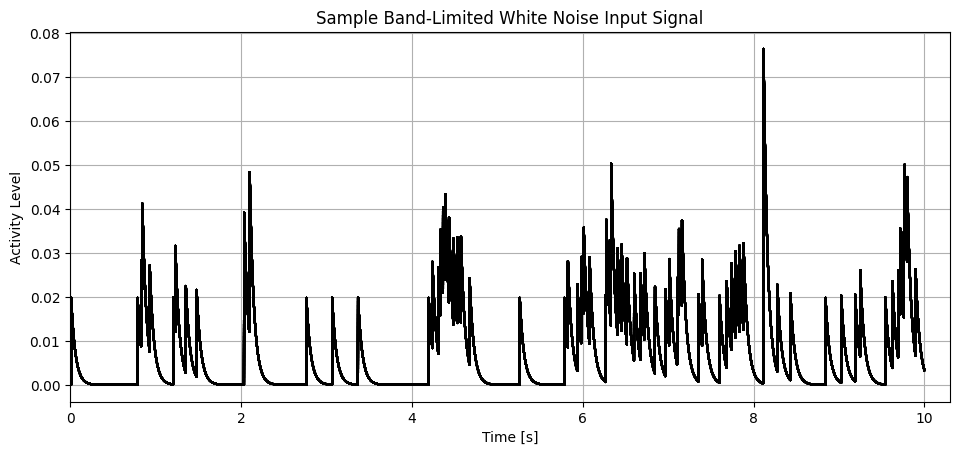

In [186]:
f, pl= plt.subplots(1,1)
f.subplots_adjust(right=1.5)

#syntax --> [;,0] -> indexing a 2D array or matrix

for i in range(49):
    pl.plot(sim.trange(), sim.data[p_stim][:,2], 'k')
    pl.set_title("Sample Band-Limited White Noise Input Signal")
    pl.set_ylabel("Activity Level")
    pl.set_xlabel("Time [s]")
    pl.set_xlim(0,10.3)

#increase synpanse constant (to stretch them out TBD)
#try to incorporate nengo representation to spread
    
pl.grid()

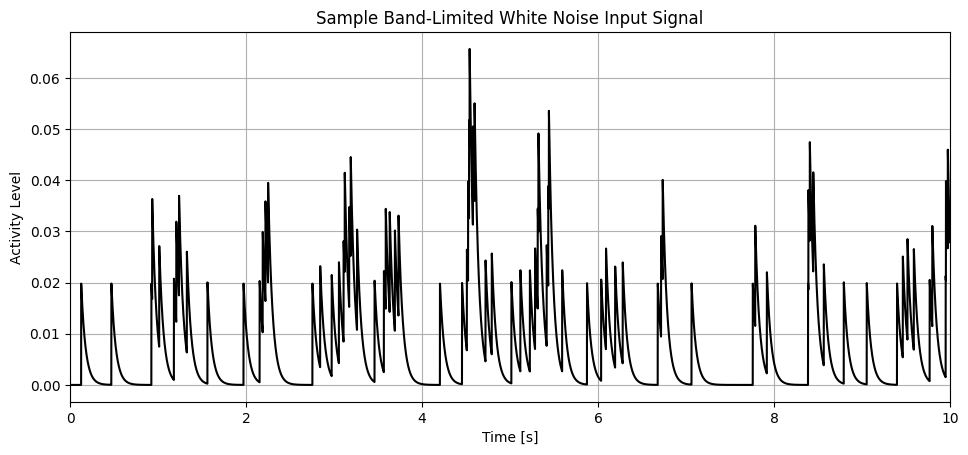

In [188]:
f, pl= plt.subplots(1,1)
f.subplots_adjust(right=1.5)

#syntax --> [;,0] -> indexing a 2D array or matrix


pl.plot(sim.trange(), sim.data[p_stim][:,4], 'k')
pl.set_title("Sample Band-Limited White Noise Input Signal")
pl.set_ylabel("Activity Level")
pl.set_xlabel("Time [s]")
pl.set_xlim(0,10)

#increase synpanse constant (to stretch them out TBD)
#try to incorporate nengo representation to spread
    
pl.grid()

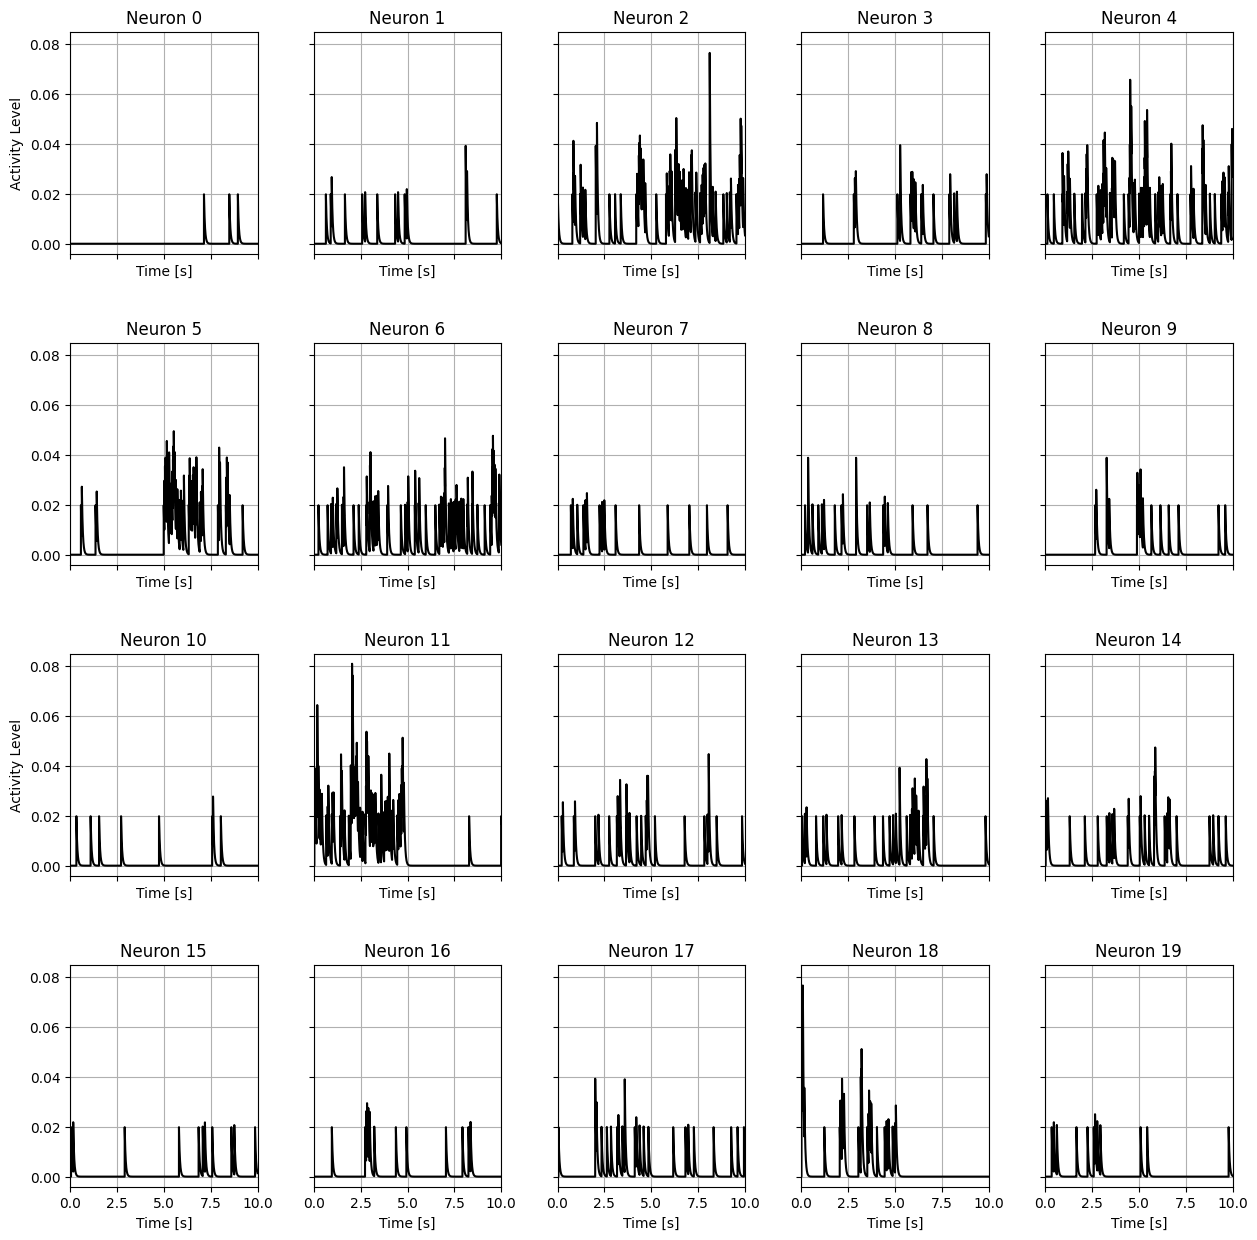

In [190]:
import matplotlib.pyplot as plt

# Number of neurons to plot
num_plots = 20  
rows = 2
cols = 10  # 2 rows, 10 columns

# Create subplots
fig, axes = plt.subplots(4, 5, figsize=(15, 15), sharey=True, sharex=True)

# Adjust layout to prevent overlap
fig.subplots_adjust(wspace=0.3, hspace=0.4)  # Space between plots

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each neuron in a separate subplot
for i in range(20):
    axes[i].plot(sim.trange(), sim.data[p_stim][:, i], 'k')
    axes[i].set_title(f"Neuron {i}")
    axes[i].set_xlabel("Time [s]")
    axes[i].set_xlim(0, 10)
    axes[i].grid()

# Set common labels
axes[0].set_ylabel("Activity Level")
axes[10].set_ylabel("Activity Level")  # Label on second row

# Show the plots
plt.show()


In [191]:
sim_t= 50
delay=0.5
with model:
    err_node= nengo.Node(lambda t,x:x if t<sim_t*0.8 else 0, size_in=2 )
    nengo.Connection(stim, err_node,synapse=IdealDelay(delay), transform=-1)
    p_err= nengo.Probe(err_node)

with nengo.Simulator(model, seed=0) as sim:
    sim.run(10)

ValidationError: init: Shape of initial value () does not match expected shape (2, 49)